This study sought to profile microRNAs (miRNAs) in skeletal muscle of a mouse model (dy3K/dy3K) of laminin alpha 2-deficient muscular dystrophy (LAMA2-CMD). miRNA levels were assessed by next-generation sequencing of quadriceps femoris samples. The raw sequencing data (FASTQ) was mapped to mature miRNA reference from miRBase using bowtie. Read counts were generated with HTSeq.

In [1]:
# Import libraries
library(DESeq2)
library(limma)
library(edgeR)
library(pheatmap)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

In [2]:
# Read count data and specify sample meta-data
count_tab = read.table('Dados/up_072_count.tsv', header=T, row.names=1)
des = data.frame(condition=c(rep('dy', 5), rep('wt', 5)), row.names=colnames(count_tab))
des$condition = relevel(des$condition, ref='wt')

In [3]:
# Create DESeq object and perform calculations
dds = DESeqDataSetFromMatrix(count_tab, des, ~ condition)
dds = DESeq(dds)
# log2 of counts; this is more robust than normTransform as it takes into account
# library size
rl = rlog(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [4]:
# Extract the results
res = results(dds)
# Significant results
sig = res[!is.na(res$padj) & res$padj < 0.05,]
# Number of significant miRNAs
nrow(sig)
# top-15 ranked by p-value
head(res[order(res$padj),], 15)

[1] 212

log2 fold change (MLE): condition dy vs wt 
Wald test p-value: condition dy vs wt 
DataFrame with 15 rows and 6 columns
                  baseMean log2FoldChange     lfcSE      stat       pvalue
                 <numeric>      <numeric> <numeric> <numeric>    <numeric>
mmu-miR-544-3p    429.4354      -2.571357 0.1662060 -15.47090 5.453811e-54
mmu-miR-3544-5p   356.4450      -2.019471 0.1595290 -12.65896 9.980984e-37
mmu-miR-376b-3p  1974.8193       1.655383 0.1402033  11.80702 3.590692e-32
mmu-miR-16-5p   48032.7070       1.862047 0.1632054  11.40923 3.760536e-30
mmu-miR-409-3p    703.9058       2.231661 0.2002426  11.14478 7.593035e-29
...                    ...            ...       ...       ...          ...
mmu-miR-133a-3p 362336.781      -1.464000 0.1571079 -9.318436 1.180673e-20
mmu-miR-133b-3p 362138.558      -1.464057 0.1571120 -9.318557 1.179328e-20
mmu-miR-154-5p    4456.092      -1.816863 0.1948717 -9.323380 1.126918e-20
mmu-miR-134-5p    3971.389       1.717918 0.1898688  9.

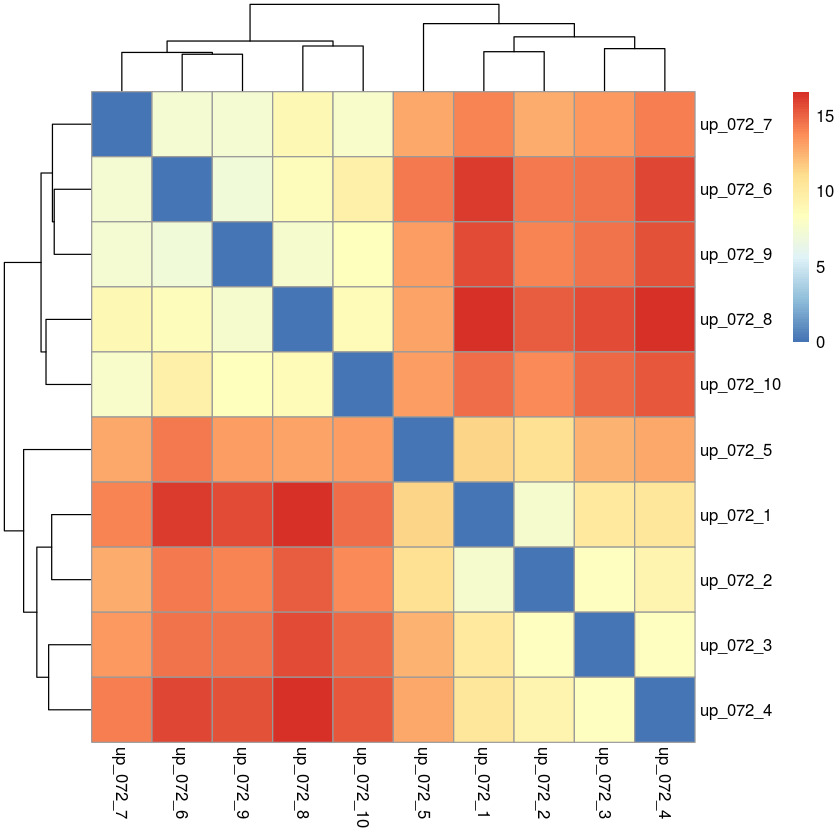

In [13]:
# Sample distances
samp_dists = dist(t(assay(rl)))
dist_mat = as.matrix(samp_dists)
pheatmap(dist_mat, clustering_distance_rows=samp_dists, clustering_distance_cols=samp_dists)

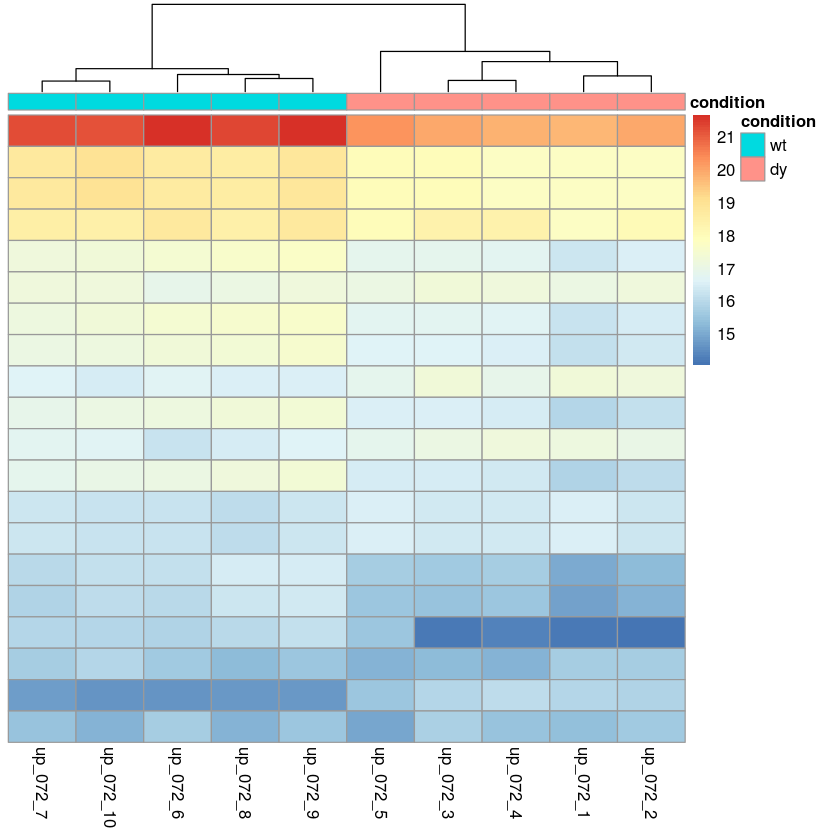

In [15]:
# Heatmap of 30 mostly expressed genes
mask = order(rowMeans(counts(dds, normalized=T)), decreasing=T)[1:20]
pheatmap(assay(rl)[mask,], cluster_rows=F, show_rownames=F, annotation_col=des)

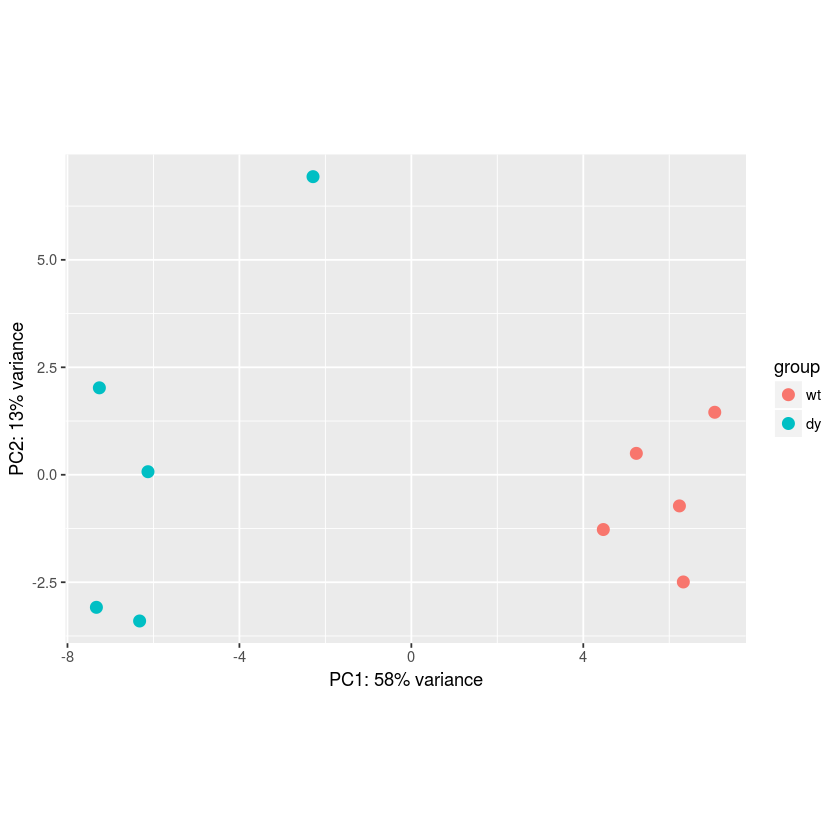

In [6]:
# PCA
plotPCA(rl, intgroup='condition')

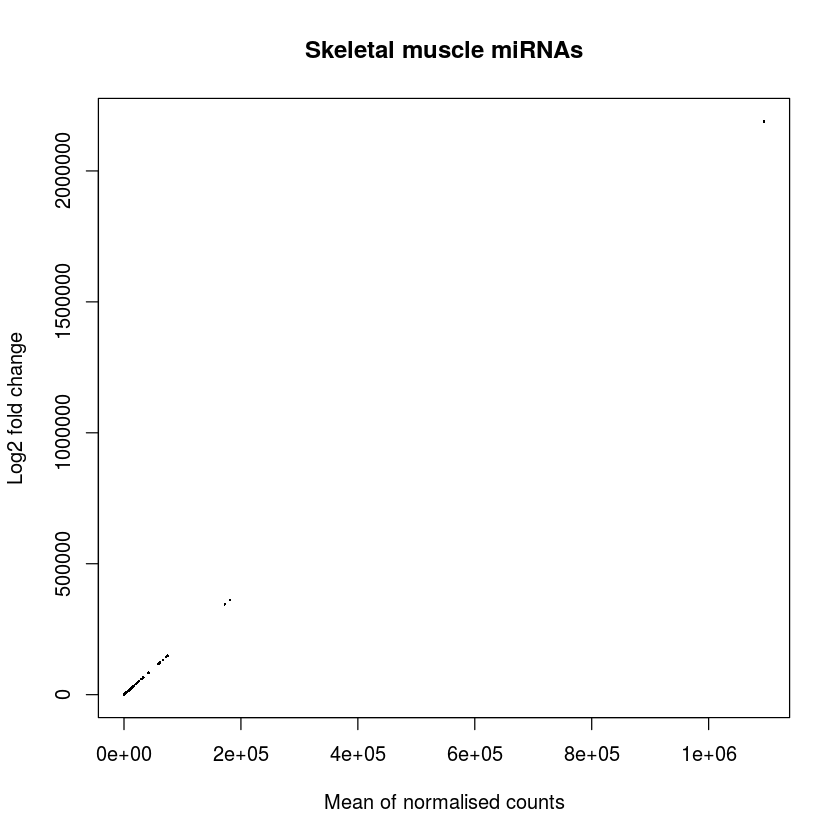

In [7]:
# MA plot
plotMA(res, main='Skeletal muscle miRNAs', xlab='Mean of normalised counts', ylab='Log2 fold change')

In [8]:
# limma workflow
keep = rowMeans(count_tab) > 10
des_mat = model.matrix(~ des$condition)
dge = DGEList(counts=count_tab[keep,])
dge = calcNormFactors(dge)

In [9]:
# DE analysis with limma-trend
log_cpm = cpm(dge, log=T)
fit_log = lmFit(log_cpm, des_mat)
fit_log = eBayes(fit_log, trend=T)
# view top-10
topTable(fit_log, coef=ncol(des_mat))
# To view all differentially expressed genes
#topTable(fit, sort.by='P', p.value=0.1, number=Inf)
limma_res = topTable(fit_log, sort.by='p', number=Inf)

logFC     AveExpr   t         P.Value      adj.P.Val   
mmu-miR-544-3p  -2.718658  5.742213 -16.96654 4.104003e-11 1.534897e-08
mmu-miR-3544-5p -2.154985  5.659192 -13.72097 7.977168e-10 1.403951e-07
mmu-miR-1a-3p   -2.437739 18.129027 -13.38173 1.126164e-09 1.403951e-07
mmu-miR-337-3p  -2.069072 11.330458 -11.28310 1.138914e-08 7.240607e-07
mmu-miR-133b-3p -1.608189 15.791304 -11.26716 1.160620e-08 7.240607e-07
mmu-miR-133a-3p -1.608131 15.792107 -11.26645 1.161595e-08 7.240607e-07
mmu-miR-22-3p   -2.084606 10.592898 -10.79335 2.055166e-08 1.098046e-06
mmu-miR-409-3p   2.096631  6.557020  10.43290 3.217026e-08 1.503960e-06
mmu-miR-154-5p  -1.982047  9.344764 -10.26291 3.990797e-08 1.658398e-06
mmu-miR-376b-3p  1.521881  8.229311  10.04827 5.259719e-08 1.827097e-06
                B        
mmu-miR-544-3p  15.858942
mmu-miR-3544-5p 12.970316
mmu-miR-1a-3p   12.629067
mmu-miR-337-3p  10.316105
mmu-miR-133b-3p 10.297089
mmu-miR-133a-3p 10.296243
mmu-miR-22-3p    9.720613
mmu-miR-409-3p   9.267344
mmu-miR-154-5p   9.048981
mmu-miR-376b-3p  8.768962

Removing intercept from test coefficients


logFC     AveExpr   t         P.Value      adj.P.Val   
mmu-miR-544-3p  -2.717970  5.743820 -16.28985 5.375676e-11 2.010503e-08
mmu-miR-3544-5p -2.158687  5.660695 -13.21166 1.046049e-09 1.754874e-07
mmu-miR-1a-3p   -2.436032 18.129027 -12.93354 1.407653e-09 1.754874e-07
mmu-miR-337-3p  -2.069924 11.330488 -11.49332 7.175253e-09 6.708861e-07
mmu-miR-22-3p   -2.082032 10.592947 -10.95725 1.372967e-08 8.061950e-07
mmu-miR-133b-3p -1.607285 15.791305 -10.88175 1.507399e-08 8.061950e-07
mmu-miR-133a-3p -1.607225 15.792108 -10.88094 1.508921e-08 8.061950e-07
mmu-miR-154-5p  -1.978655  9.344878 -10.36583 2.894107e-08 1.291856e-06
mmu-miR-409-3p   2.097704  6.558142  10.31042 3.108745e-08 1.291856e-06
mmu-miR-376b-3p  1.519554  8.229628  10.10698 4.052881e-08 1.515778e-06
                B        
mmu-miR-544-3p  15.574959
mmu-miR-3544-5p 12.686995
mmu-miR-1a-3p   12.326835
mmu-miR-337-3p  10.735554
mmu-miR-22-3p   10.084798
mmu-miR-133b-3p  9.925695
mmu-miR-133a-3p  9.924649
mmu-miR-154-5p   9.339586
mmu-miR-409-3p   9.288062
mmu-miR-376b-3p  9.004036

Removing intercept from test coefficients


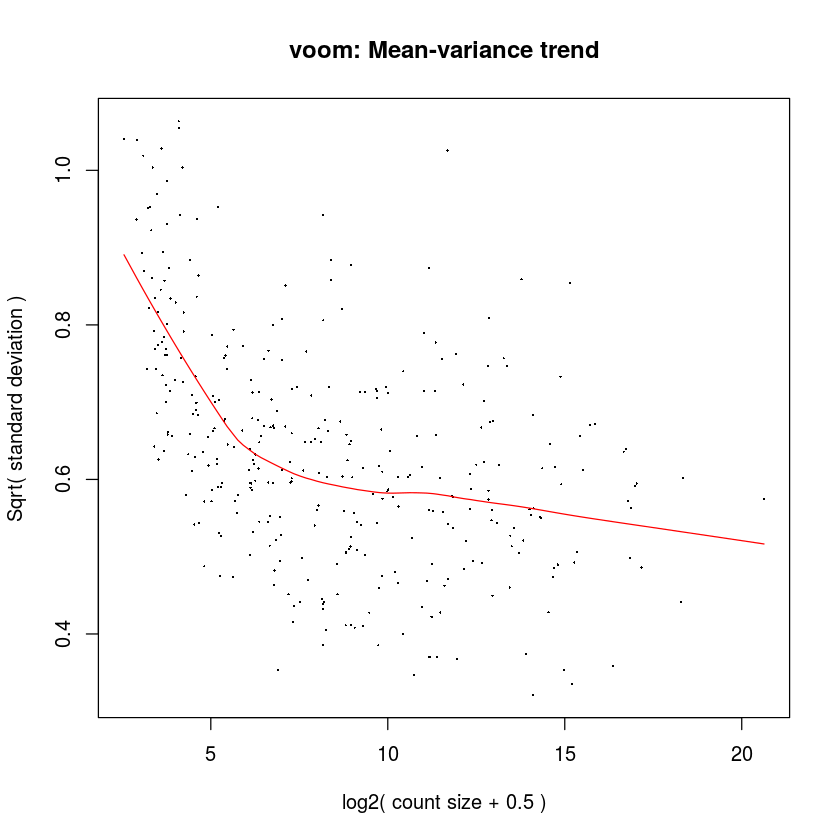

In [10]:
# DE analysis with voom
v = voom(dge, des_mat, plot=T)
fit_v = lmFit(v, des_mat)
fit_v = eBayes(fit_v)
topTable(fit_v, coef=ncol(des_mat))
voom_res = topTable(fit_v, sort.by='p', number=Inf)

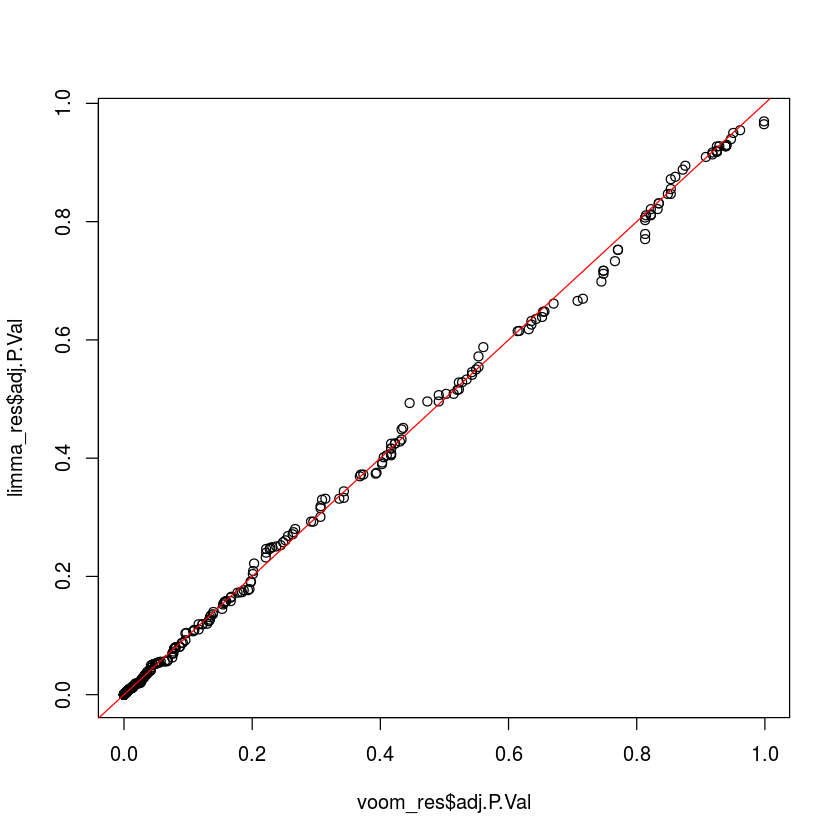

In [11]:
# p-value scatter of limma and voom values
plot(voom_res$adj.P.Val, limma_res$adj.P.Val)
abline(0, 1, col='red')

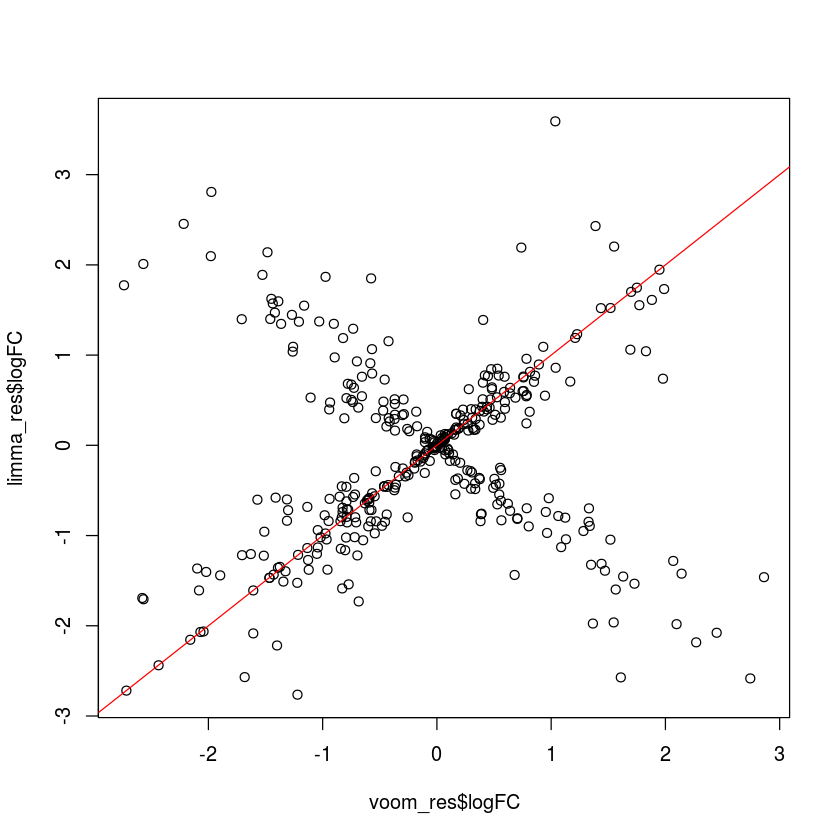

In [12]:
# scatter of log2 fold change
plot(voom_res$logFC, limma_res$logFC)
abline(0, 1, col='red')